# Install needed libraries

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.2 MB/s eta 0:00:00


# Import needed libariries

In [ ]:
import tensorflow as tf
import torch
from google.colab import drive
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import numpy as np
import time
import datetime
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
#% matplotlib inline

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.enabled = False
os.environ['PYTHONHASHSEED'] = str(seed_val)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_val)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Use GPU

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Loading Dataset

In [ ]:
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
domain = "Social_Networking"
#domain = "Games"
#domain = "Productivity"
NUM_OF_CLASSES = 9

X_train_url = ""
y_train_url = ""
X_test_url = ""
y_test_url = ""

if domain == "Social_Networking":
  X_train_url = "https://drive.google.com/uc?id=1-oze2ZVpgZ2hodIlZn7ro9Yh9xewBCH9&export=download"
  y_train_url = "https://drive.google.com/uc?id=1-kszADYLrGNGrDWx8E7EUpHiyzix4-Iw&export=download"
  X_test_url = "https://drive.google.com/uc?id=1-kjhYg0Nvv09JzETw876sViI8XTDpsF7&export=download"
  y_test_url = "https://drive.google.com/uc?id=1-qbR1VBDBrjpLJCRHNJY7GOOHHMkKNif&export=download"
elif domain == "Games":
  X_train_url = "https://drive.google.com/uc?id=1-cP2d8l7OKxkPDvRT455qw4y7DHPdChR&export=download"
  y_train_url = "https://drive.google.com/uc?id=1-Q-XNyBzcBEaa4u7G0XWYtFIVGEjeUK-&export=download"
  X_test_url = "https://drive.google.com/uc?id=1-KstbnjDRQykVxBLp9JAoE-ZcXoBK06u&export=download"
  y_test_url = "https://drive.google.com/uc?id=1-f7ONCkmpds20ZCrJepkInHr8ip8WNhF&export=download"
elif domain == "Productivity":
  X_train_url = "https://drive.google.com/uc?id=13sdG58GCMU3bvtOgpT6NVuFXyBlhO8cg&export=download"
  y_train_url = "https://drive.google.com/uc?id=15F8IRKD2isn1fyFH4SF49k-3aZPU77su&export=download"
  X_test_url = "https://drive.google.com/uc?id=1_ttANznHm8p39uUTtCKWbFe8rVqCk1Vd&export=download"
  y_test_url = "https://drive.google.com/uc?id=1-18dZRGT2SC9aHCLJ6hsyMuzoSJICMPK&export=download"


In [ ]:
import pickle

with open(X_train_url,'rb') as pickle_file:
    X_train = pickle.load(pickle_file)

with open(y_train_url,'rb') as pickle_file:
    y_train = pickle.load(pickle_file)

with open(X_test_url,'rb') as pickle_file:
    X_test = pickle.load(pickle_file)

with open(y_test_url,'rb') as pickle_file:
    y_test = pickle.load(pickle_file)

In [ ]:
X_train = X_train['sentence'].values
X_test = X_test['sentence'].values

y_train = y_train.values
y_test = y_test.values

In [ ]:
np.where(pd.isnull(X_train))

(array([], dtype=int64),)

In [ ]:
X_train = np.delete(X_train, [163, 1250], axis=0)
y_train =  np.delete(y_train, [163, 1250], axis=0)

In [ ]:
sentences = np.concatenate([X_train,X_test])

In [ ]:
np.unique(y_train)

array([ 1,  3,  4,  5,  6,  8,  9, 10, 11])

In [ ]:
y_train = np.where(y_train == 1, 0, y_train)
y_train = np.where(y_train == 3, 1, y_train)
y_train = np.where(y_train == 4, 2, y_train)
y_train = np.where(y_train == 5, 3, y_train)
y_train = np.where(y_train == 6, 4, y_train)
y_train = np.where(y_train == 8, 5, y_train)
y_train = np.where(y_train == 9, 6, y_train)
y_train = np.where(y_train == 10, 7, y_train)
y_train = np.where(y_train == 11, 8, y_train)

In [ ]:
y_test = np.where(y_test == 1, 0, y_test)
y_test = np.where(y_test == 3, 1, y_test)
y_test = np.where(y_test == 4, 2, y_test)
y_test = np.where(y_test == 5, 3, y_test)
y_test = np.where(y_test == 6, 4, y_test)
y_test = np.where(y_test == 8, 5, y_test)
y_test = np.where(y_test == 9, 6, y_test)
y_test = np.where(y_test == 10, 7, y_test)
y_test = np.where(y_test == 11, 8, y_test)

In [ ]:
'''
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.category_id.values

 X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, random_state=seed_val, stratify = labels)
 '''

# Tokenization & Input Formatting

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:
  
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_train: #sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
                      sent,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      max_length = max_len,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                )
  
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])
  
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', X_train[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  And also taking away the ability to delete group chats was a poor decision
Token IDs: tensor([  101,  1998,  2036,  2635,  2185,  1996,  3754,  2000,  3972, 12870,
         2177, 11834,  2015,  2001,  1037,  3532,  3247,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])


# Training

## Training & Validation Split

In [ ]:
def split_dataset(batch_size):
  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create a 90-10 train-validation split.

  # Calculate the number of samples to include in each set.
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  # Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order.
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size, # Trains with this batch size.
              num_workers = 0,
              worker_init_fn = seed_worker,
              generator = g
          )
  
  

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size, # Evaluate with this batch size.
              num_workers = 0,
              worker_init_fn = seed_worker,
              generator = g
          )

  return train_dataloader, validation_dataloader

## Helper Functions

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Training Loop

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

def train(learning_rate, batch_size, num_epochs, train_dataloader, validation_dataloader):
  
  # ========================================
  #   Load BertForSequenceClassification
  # ========================================

  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = NUM_OF_CLASSES, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
      return_dict=False
  )

  # Set number of epochs
  epochs = num_epochs

  # Tell pytorch to run this model on the GPU.
  model.cuda()

  # ========================================
  #               Create Adam Optemizer
  # ========================================

  # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                    lr = learning_rate, # args.learning_rate - default is 5e-5, 
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

    
  # ========================================
  #               Create Scheduler
  # ========================================


  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)


  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          #if step == 0:
          #  print(type(batch))
          #  print(batch[0])

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
     
          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

      # Save performance of this epoch
      if epoch_i > 0:
        export_training_summary(learning_rate, epoch_i + 1, batch_size, training_stats)
        save_model(model, learning_rate,  epoch_i + 1, batch_size)

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return model

## Training Summary

In [ ]:
def export_training_summary(learning_rate, epoch, batch_size, training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # A hack to force the column headers to wrap.
  #df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

  df_stats.to_csv("/content/drive/MyDrive/RE/Results/DL/ACD/"+domain+'_'+str(learning_rate)+'_'+str(epoch)+'_'+str(batch_size)+'.csv')

  # Display the table.
  print(df_stats.head())

  #plot_loss(df_stats)

In [ ]:
def plot_loss(df_stats):
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()
  plt.savefig('/content/drive/MyDrive/RE/Results/DL/ACD/valid_train_loss.png', dpi=300)

# Saving the Model

In [ ]:
'''
def save_model(model, learning_rate, epoch, batch_size):
  # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

  output_dir = '/content/drive/MyDrive/RE/Results/DL/ACD/'+domain+'/'+str(learning_rate)+'_'+str(epoch)+'_'+str(batch_size)

  # Create output directory if needed
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  # Save a trained model, configuration and tokenizer using `save_pretrained()`.
  # They can then be reloaded using `from_pretrained()`
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)

  # Good practice: save your training arguments together with the trained model
  # torch.save(args, os.path.join(output_dir, 'training_args.bin'))
'''

# Hyper-parameters Tuning

In [ ]:
LEARNING_RATES = [2e-5, 3e-5, 5e-5]
#EPOCHS = [2, 3, 4] # The BERT authors recommend between 2 and 4. 
BATCH_SIZES = [16, 32] #For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

for BATCH_SIZE in BATCH_SIZES:
  train_dataloader, validation_dataloader = split_dataset(BATCH_SIZE)
  #for EPOCH in EPOCHS:
  for LEARNING_RATE in LEARNING_RATES:
    model = train(LEARNING_RATE, BATCH_SIZE, 4, train_dataloader, validation_dataloader)
      
      


1,963 training samples
  219 validation samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    123.    Elapsed: 0:00:05.
  Batch    80  of    123.    Elapsed: 0:00:10.
  Batch   120  of    123.    Elapsed: 0:00:15.

  Average training loss: 1.90
  Training epcoh took: 0:00:15

Running Validation...
  Accuracy: 0.38
  Validation Loss: 1.77
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    123.    Elapsed: 0:00:05.
  Batch    80  of    123.    Elapsed: 0:00:10.
  Batch   120  of    123.    Elapsed: 0:00:15.

  Average training loss: 1.63
  Training epcoh took: 0:00:15

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.56
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.90         1.77           0.38       0:00:15         0:00:00
2               1.63         1.56           0.44       0:00:15         0:00:00
Saving mod

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    123.    Elapsed: 0:00:06.
  Batch    80  of    123.    Elapsed: 0:00:11.
  Batch   120  of    123.    Elapsed: 0:00:16.

  Average training loss: 1.92
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.40
  Validation Loss: 1.71
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    123.    Elapsed: 0:00:05.
  Batch    80  of    123.    Elapsed: 0:00:10.
  Batch   120  of    123.    Elapsed: 0:00:15.

  Average training loss: 1.61
  Training epcoh took: 0:00:15

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.53
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.92         1.71           0.40       0:00:16         0:00:00
2               1.61         1.53           0.44       0:00:15         0:00:00
Saving mod

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    123.    Elapsed: 0:00:06.
  Batch    80  of    123.    Elapsed: 0:00:11.
  Batch   120  of    123.    Elapsed: 0:00:16.

  Average training loss: 1.82
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.42
  Validation Loss: 1.56
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    123.    Elapsed: 0:00:05.
  Batch    80  of    123.    Elapsed: 0:00:10.
  Batch   120  of    123.    Elapsed: 0:00:14.

  Average training loss: 1.55
  Training epcoh took: 0:00:15

Running Validation...
  Accuracy: 0.47
  Validation Loss: 1.52
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.82         1.56           0.42       0:00:16         0:00:00
2               1.55         1.52           0.47       0:00:15         0:00:00
Saving mod

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:07.

  Average training loss: 2.01
  Training epcoh took: 0:00:11

Running Validation...
  Accuracy: 0.25
  Validation Loss: 1.94
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training loss: 1.86
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.29
  Validation Loss: 1.90
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               2.01         1.94           0.25       0:00:11         0:00:00
2               1.86         1.90           0.29       0:00:10         0:00:00
Saving model to /content/drive/MyDrive/RE/Results/DL/ACD/Social_Networking/2e-05_2_32

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training lo

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:07.

  Average training loss: 1.90
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.31
  Validation Loss: 1.86
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training loss: 1.66
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.32
  Validation Loss: 1.79
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.90         1.86           0.31       0:00:10         0:00:00
2               1.66         1.79           0.32       0:00:10         0:00:00
Saving model to /content/drive/MyDrive/RE/Results/DL/ACD/Social_Networking/3e-05_2_32

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training lo

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:07.

  Average training loss: 1.91
  Training epcoh took: 0:00:11

Running Validation...
  Accuracy: 0.31
  Validation Loss: 1.83
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training loss: 1.60
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.39
  Validation Loss: 1.68
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.91         1.83           0.31       0:00:11         0:00:00
2               1.60         1.68           0.39       0:00:10         0:00:00
Saving model to /content/drive/MyDrive/RE/Results/DL/ACD/Social_Networking/5e-05_2_32

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training lo

# Re-train with the best hyperparameters

In [ ]:
model = train(3e-05, 16, 3, train_dataloader, validation_dataloader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 3 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:10.

  Average training loss: 1.93
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.30
  Validation Loss: 1.84
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training loss: 1.61
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.37
  Validation Loss: 1.71
  Validation took: 0:00:00
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.93         1.84           0.30       0:00:14         0:00:00
2               1.61         1.71           0.37       0:00:10         0:00:00
Saving model to /content/drive/MyDrive/RE/Results/DL/ACD/Social_Networking/3e-05_2_16

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     62.    Elapsed: 0:00:06.

  Average training lo

# Evaluation

In [ ]:
# Create sentence and label lists
#sentences = df.sentence.values
#labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        #pad_to_max_length = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
#model.cuda()
model.eval()

#loaded_model.cuda()
#loaded_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  #batch = tuple(t for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 936 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the acc, recall, precision, and f1-score
acc = accuracy_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions, average='micro')
precision = precision_score(flat_true_labels, flat_predictions, average='micro')
f1 = f1_score(flat_true_labels, flat_predictions, average='micro')

print('Total Accuracy: %.9f' % acc)
print('Total recall: %.9f' % recall)
print('Total precision: %.9f' % precision)
print('Total f1: %.9f' % f1)

Total Accuracy: 0.428418803
Total recall: 0.428418803
Total precision: 0.428418803
Total f1: 0.428418803


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating accuracy for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  accuracy = accuracy_score(true_labels[i], pred_labels_i)                
  accuracy_set.append(accuracy)

Calculating accuracy for each batch...


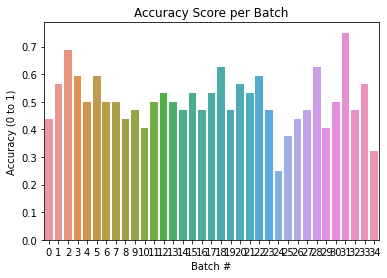

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(accuracy_set))), y=accuracy_set, ci=None)

plt.title('Accuracy Score per Batch')
plt.ylabel('Accuracy (0 to 1)')
plt.xlabel('Batch #')

plt.show()